# getting data

In [1]:
#This gets us into the right directory from home, in order to run the import python script from Mat

#sys = system (module), gives information and control over python interpreter/terminal itself
import sys
sys.path.append("/home/565/pv3484/aus_substation_electricity")

#% is a magic command, special shortcut command that lets you control/interact with notebook environment (ie. gives control of terminal without writing full python code)
%cd aus_substation_electricity/

!pwd

/home/565/pv3484/aus_substation_electricity
/home/565/pv3484/aus_substation_electricity


In [2]:
#This section imports the substations that Mat put together

%run /home/565/pv3484/aus_substation_electricity/import_substation.py

processing nsw substations for ['ausgrid'] from None to None
ausgrid
following columns in demand are not in info index:
['MT_HU', 'SI_NO']
removing these columns from demand
number of substations in ausgrid substation info: 134
number of substations in ausgrid substation data: 132
following sites match selection criteria:
               energy_asset          Name  Area  Dwellings  Persons  Residential  Commercial  Industrial  Primary Production  Education  \
ID                                                                                                                                        
BLAKE         AG_BLAKEHURST    Blakehurst     7      10081    28521        0.850       0.005       0.021               0.000      0.022   
PUNCH          AG_PUNCHBOWL     Punchbowl     9      17514    50395        0.826       0.048       0.038               0.000      0.025   
MEADO         AG_MEADOWBANK    Meadowbank    15      22420    56948        0.825       0.023       0.015               0

# Goal of this notebook: Animate Demand for a given year and date
- Visualise how demand differs across the locations within the Greater Sydney Region
- Use animatations

## Adding lat and long to substations

In [17]:
from geopy.geocoders import Nominatim
import pandas as pd
import time

# Initialize geocoder
geolocator = Nominatim(user_agent="sydney_demand_mapper")

def get_coords(place):
    """Return (lat, lon) for a suburb name, or (None, None) if not found."""
    try:
        loc = geolocator.geocode(f"{place}, Sydney, Australia")
        if loc:
            return loc.latitude, loc.longitude
    except Exception as e:
        print(f"Geocoding failed for {place}: {e}")
    return None, None

# Apply geocoding to the 'Name' column
latitudes, longitudes = [], []
for suburb in info['Name']:
    lat, lon = get_coords(suburb)
    latitudes.append(lat)
    longitudes.append(lon)
    time.sleep(1)  # polite pause to avoid hitting API limits

info['latitude'] = latitudes
info['longitude'] = longitudes

In [19]:
info.head(5)

,energy_asset,Name,Area,Dwellings,Persons,Residential,Commercial,Industrial,Primary Production,Education,Hospital/Medical,Transport,Parkland,Water,Other,latitude,longitude
BLAKE,AG_BLAKEHURST,Blakehurst,7,10081,28521,0.850,0.005,0.021,0.0,0.022,0.001,0.000,0.102,0.0,0.0,-33.989852,151.108560
PUNCH,AG_PUNCHBOWL,Punchbowl,9,17514,50395,0.826,0.048,0.038,0.0,0.025,0.002,0.001,0.061,0.0,0.0,-33.925413,151.055761
MEADO,AG_MEADOWBANK,Meadowbank,15,22420,56948,0.825,0.023,0.015,0.0,0.036,0.014,0.006,0.082,0.0,0.0,-33.821312,151.090230
MOSMA,AG_MOSMAN,Mosman,11,25967,52831,0.817,0.046,0.001,0.0,0.013,0.001,0.000,0.123,0.0,0.0,-33.829807,151.243444
RIVER,AG_RIVERWOOD,Riverwood,10,12528,34547,0.813,0.018,0.042,0.0,0.035,0.002,0.001,0.089,0.0,0.0,-33.951506,151.052118


## Heatmapping

In [75]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import os

def animate_sydney_heatmap(demand, info, date,
                           lat_col="latitude", lon_col="longitude",
                           cmap="viridis", fps=4,
                           output_dir="/home/565/pv3484/aus_substation_electricity/figures/map_animation",
                           filename_prefix="sydney_demand"):
    """
    Animated heatmap of electricity demand over 24 hours for a given day,
    using lat/lon from `info`. Demand is normalized per substation (0–1).
    """

    target_date = pd.to_datetime(date).normalize()
    demand.index = pd.to_datetime(demand.index)

    # Filter for the given day
    day_data = demand[demand.index.normalize() == target_date]
    if day_data.empty:
        raise ValueError(f"No demand data found for {target_date.date()}.")

    # Reshape wide → long
    day_long = day_data.reset_index().melt(
        id_vars=[day_data.index.name or 'index'],
        var_name="substation",
        value_name="demand"
    )
    day_long.rename(columns={day_data.index.name or 'index': "timestamp"}, inplace=True)

    # Reset info index safely
    info_reset = info.reset_index().rename(columns={info.index.name or "index": "substation"})
    info_reset = info_reset.loc[:, ~info_reset.columns.duplicated()]

    # Merge demand + metadata
    merged = day_long.merge(info_reset, on="substation", how="left")
    if merged.empty:
        raise ValueError("Merge produced no rows. Check substation IDs and info index alignment.")

    # Normalize demand per substation
    merged["norm_demand"] = merged.groupby("substation")["demand"].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0
    )

    # Unique timestamps
    timestamps = merged['timestamp'].sort_values().unique()

    # Fixed color scale (0–1 for all substations)
    vmin, vmax = 0, 1

    # Setup figure and initial scatter
    fig, ax = plt.subplots(figsize=(8,6))
    subset0 = merged[merged['timestamp'] == timestamps[0]]
    sc = ax.scatter(subset0[lon_col], subset0[lat_col],
                    c=subset0["norm_demand"], cmap=cmap, s=100,
                    vmin=vmin, vmax=vmax)
    plt.colorbar(sc, ax=ax, label="Normalized Demand (0–1)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"Sydney Demand (normalized per substation) on {target_date.date()} at {timestamps[0].strftime('%H:%M')}")

    def update(frame):
        ts = timestamps[frame]
        subset = merged[merged['timestamp'] == ts]
        sc.set_offsets(subset[[lon_col, lat_col]].values)
        sc.set_array(subset["norm_demand"].values)
        ax.set_title(f"Sydney Demand (normalized per substation) on {target_date.date()} at {ts.strftime('%H:%M')}")
        return sc,

    ani = animation.FuncAnimation(fig, update, frames=len(timestamps), blit=False)

    # Ensure output folder exists
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"{target_date.date()}_normalized.gif")

    ani.save(output_path, writer="pillow", fps=fps)
    return ani

## Normalised Demand

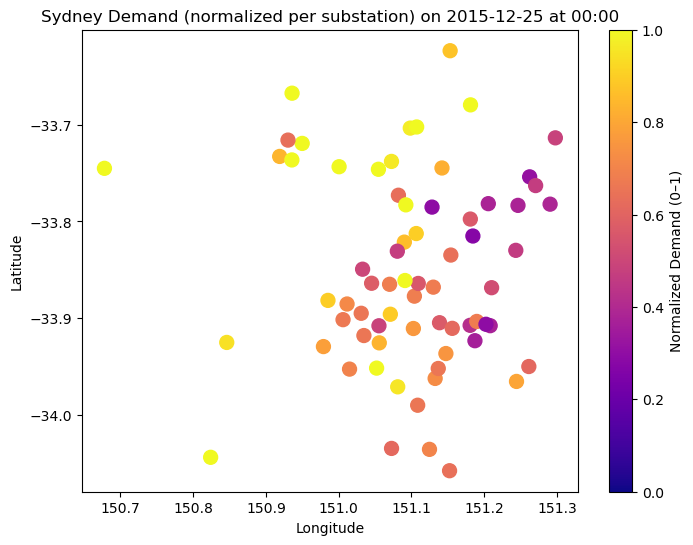

In [76]:
ani = animate_sydney_heatmap(
    demand=demand,
    info=info,
    date="2015-12-25",
    cmap="plasma",
    fps=6
)

## Looping through all public holidays and years with saving function
- using code above but including a loop to generate gif for all holidays for all years

### Holiday Dictionary

In [79]:
# -------------------------------
# Holiday functions and registry
# -------------------------------

def new_years_day(year): return pd.Timestamp(f"{year}-01-01")
def australia_day(year): return pd.Timestamp(f"{year}-01-26")
def anzac_day(year): return pd.Timestamp(f"{year}-04-25")
def good_friday(year): return easter(year) - timedelta(days=2)
def easter_saturday(year): return easter(year) - timedelta(days=1)
def easter_sunday(year): return easter(year)
def easter_monday(year): return easter(year) + timedelta(days=1)
def christmas_day(year): return pd.Timestamp(f"{year}-12-25")
def boxing_day(year): return pd.Timestamp(f"{year}-12-26")

HOLIDAYS = {
    "New Year’s Day": new_years_day,
    "Australia Day": australia_day,
    "ANZAC Day": anzac_day,
    "Good Friday": good_friday,
    "Easter Saturday": easter_saturday,
    "Easter Sunday": easter_sunday,
    "Easter Monday": easter_monday,
    "Christmas Day": christmas_day,
    "Boxing Day": boxing_day,
}


In [80]:
from pathlib import Path
from datetime import datetime

def batch_animate_holidays(demand, info, holidays_dict,
                           years=range(2004, 2018),
                           base_dir="/home/565/pv3484/aus_substation_electricity/figures/map_animation",
                           lat_col="latitude", lon_col="longitude",
                           cmap="viridis", fps=4,
                           log_filename="batch_log.txt"):
    """
    Loops through all years and holidays, generating one animation per holiday per year.
    Saves each GIF into a subfolder named after the holiday.
    Logs successes and failures to a text file.
    """

    log_path = Path(base_dir) / log_filename
    with open(log_path, "w") as log:
        log.write(f"Batch run started at {datetime.now()}\n\n")

        for holiday_name, holiday_func in holidays_dict.items():
            for year in years:
                try:
                    # Get holiday date
                    date = holiday_func(year)
                    date_str = date.strftime("%Y-%m-%d")

                    # Build output folder and filename
                    folder = Path(base_dir) / holiday_name.replace(" ", "_")
                    folder.mkdir(parents=True, exist_ok=True)
                    filename = f"sydney_demand_{date_str}_normalized.gif"
                    output_path = folder / filename

                    # Run animation
                    animate_sydney_heatmap(
                        demand=demand,
                        info=info,
                        date=date,
                        lat_col=lat_col,
                        lon_col=lon_col,
                        cmap=cmap,
                        fps=fps,
                        output_dir=str(folder),
                        filename_prefix=f"sydney_demand_{date_str}"
                    )

                    msg = f"✅ Saved: {output_path}"
                    print(msg)
                    log.write(msg + "\n")

                except Exception as e:
                    msg = f"⚠️ Skipped {holiday_name} {year}: {e}"
                    print(msg)
                    log.write(msg + "\n")

        log.write(f"\nBatch run completed at {datetime.now()}\n")

In [ ]:
batch_animate_holidays(
    demand=demand,
    info=info,
    holidays_dict=HOLIDAYS,
    years=range(2004, 2018),
    cmap="plasma",
    fps=6
)

✅ Saved: /home/565/pv3484/aus_substation_electricity/figures/map_animation/New_Year’s_Day/sydney_demand_2004-01-01_normalized.gif
✅ Saved: /home/565/pv3484/aus_substation_electricity/figures/map_animation/New_Year’s_Day/sydney_demand_2005-01-01_normalized.gif
✅ Saved: /home/565/pv3484/aus_substation_electricity/figures/map_animation/New_Year’s_Day/sydney_demand_2006-01-01_normalized.gif
✅ Saved: /home/565/pv3484/aus_substation_electricity/figures/map_animation/New_Year’s_Day/sydney_demand_2007-01-01_normalized.gif
✅ Saved: /home/565/pv3484/aus_substation_electricity/figures/map_animation/New_Year’s_Day/sydney_demand_2008-01-01_normalized.gif
✅ Saved: /home/565/pv3484/aus_substation_electricity/figures/map_animation/New_Year’s_Day/sydney_demand_2009-01-01_normalized.gif
✅ Saved: /home/565/pv3484/aus_substation_electricity/figures/map_animation/New_Year’s_Day/sydney_demand_2010-01-01_normalized.gif
✅ Saved: /home/565/pv3484/aus_substation_electricity/figures/map_animation/New_Year’s_Day/

/jobfs/156433640.gadi-pbs/ipykernel_953501/3806121720.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8,6))


✅ Saved: /home/565/pv3484/aus_substation_electricity/figures/map_animation/Australia_Day/sydney_demand_2010-01-26_normalized.gif
✅ Saved: /home/565/pv3484/aus_substation_electricity/figures/map_animation/Australia_Day/sydney_demand_2011-01-26_normalized.gif
✅ Saved: /home/565/pv3484/aus_substation_electricity/figures/map_animation/Australia_Day/sydney_demand_2012-01-26_normalized.gif
✅ Saved: /home/565/pv3484/aus_substation_electricity/figures/map_animation/Australia_Day/sydney_demand_2013-01-26_normalized.gif
